In [481]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt

## Exploration and Cleaning
First lets take a look at what kinds of data we have.  
At a glance, it looks like the columns we care about for final analysis will be:  
- Fruit, the type of fruit for the entry (Apples, Raspberries, etc)
- Form, the form that fruit takes (Canned, Dried, Fresh, Frozen, or Juice)
- CupEquivalentPrice, the cost of this entry of fruit in USD/cup

The other 5 columns apear to be used to calculate CupEquivalentPrice,  
so we'll drop those.

In [485]:
file = "Fruit-Prices-2022.csv"
data = pd.read_csv(file)
print(data.columns)
print(data)
data = data.drop(columns=['RetailPrice','RetailPriceUnit', 'Yield', 'CupEquivalentSize',
       'CupEquivalentUnit'])

Index(['Fruit', 'Form', 'RetailPrice', 'RetailPriceUnit', 'Yield',
       'CupEquivalentSize', 'CupEquivalentUnit', 'CupEquivalentPrice'],
      dtype='object')
                         Fruit    Form  RetailPrice RetailPriceUnit  Yield  \
0                       Apples   Fresh       1.8541       per pound   0.90   
1           Apples, applesauce  Canned       1.1705       per pound   1.00   
2       Apples, ready-to-drink   Juice       0.8699        per pint   1.00   
3   Apples, frozen concentrate   Juice       0.6086        per pint   1.00   
4                     Apricots   Fresh       3.6162       per pound   0.93   
..                         ...     ...          ...             ...    ...   
57                 Raspberries   Fresh       7.7338       per pound   0.96   
58                 Raspberries  Frozen       6.1590       per pound   1.00   
59                Strawberries   Fresh       2.9682       per pound   0.94   
60                Strawberries  Frozen       3.3421       p

## Cleaning (Cont.)
It looks like some fruits have multiple different labels in the Fruit column;  
Let's clean that up to make comparison within a specific fruit possible.  
That is, we'll make 'Apples' and 'Apples, applesauce' equivalent.  
Additionally, some fruits also only have a single entry.  
We'll remove those to focus fruits with at least 2 rows present.

In [566]:
print("initial Fruit values:\n")
print(data["Fruit"].values, "\n")

fruits = data["Fruit"].values
for i in range(len(fruits)):
    for j in range(len(fruits[i])):
        if fruits[i][j] == ',' or fruits[i][j] == ' ':
            fruits[i] = fruits[i][:j]
            break
print("Modified Fruit values:\n")
print(data["Fruit"].values)

data2 = data.drop_duplicates(subset="Fruit", keep=False)

for i in data2.index:
    data = data.drop(index=i)
print("Final Fruit Values")
print(data["Fruit"].values)

initial Fruit values:

['Apples' 'Apples' 'Apples' 'Apples' 'Apricots' 'Apricots' 'Apricots'
 'Apricots' 'Blackberries' 'Blackberries' 'Blueberries' 'Blueberries'
 'Cherries' 'Cherries' 'Fruit' 'Fruit' 'Grapefruit' 'Grapefruit' 'Grapes'
 'Grapes' 'Grapes' 'Grapes' 'Mangoes' 'Mangoes' 'Oranges' 'Oranges'
 'Oranges' 'Papaya' 'Papaya' 'Peaches' 'Peaches' 'Peaches' 'Peaches'
 'Pears' 'Pears' 'Pears' 'Pineapple' 'Pineapple' 'Pineapple' 'Pineapple'
 'Pineapple' 'Pineapple' 'Plum' 'Plum' 'Plum' 'Pomegranate' 'Pomegranate'
 'Raspberries' 'Raspberries' 'Strawberries' 'Strawberries'] 

Modified Fruit values:

['Apples' 'Apples' 'Apples' 'Apples' 'Apricots' 'Apricots' 'Apricots'
 'Apricots' 'Blackberries' 'Blackberries' 'Blueberries' 'Blueberries'
 'Cherries' 'Cherries' 'Fruit' 'Fruit' 'Grapefruit' 'Grapefruit' 'Grapes'
 'Grapes' 'Grapes' 'Grapes' 'Mangoes' 'Mangoes' 'Oranges' 'Oranges'
 'Oranges' 'Papaya' 'Papaya' 'Peaches' 'Peaches' 'Peaches' 'Peaches'
 'Pears' 'Pears' 'Pears' 'Pineapple' 'Pine

## Cost / Form Analysis
Let's first take a look at the relationship between Form and price.
Looking at the chart below, Juice appears to be the cheapest Form overall.  
- Fresh has the widest distribution of all the forms, although the highest priced entry is an outlier of the Canned form.
- Dried has a rather tight distribution almost entirely between 1-1.5 USD/Cup.

CupEquivalentPrice    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

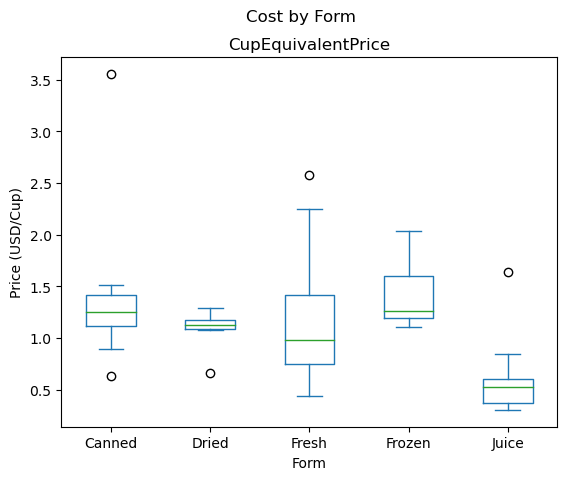

In [501]:
data.plot.box(column=["CupEquivalentPrice"], by="Form", title="Cost by Form", xlabel="Form", ylabel="Price (USD/Cup)")

## Initial Within Fruit Comparison
To get some more useful information, we want to compare the price between forms within each type of fruit.  
There's some information in just looking at the common forms for the high and low end of each fruit,  
However not much can be said here since there is an uneven distribution of types,  
with Fresh entries making up the majority of both the highest and lowest prices for each type of fruit.

In [264]:
print("minimums:")
print(data.groupby("Fruit").min().value_counts("Form"))
print("maximums:")
print(data.groupby("Fruit").max().value_counts("Form"))

minimums:
Form
Fresh     14
Canned     7
Dried      7
Frozen     1
Name: count, dtype: int64
maximums:
Form
Fresh     12
Juice      7
Frozen     6
Dried      3
Canned     1
Name: count, dtype: int64


## Improved Within Fruit Analysis
To get a normalized look at the relative costs for each form within each type of fruit,  
we'll impliment a method to rank each form on how it costs relative to other forms within each fruit.  
We'll use a point system with each entry gaining or losing points. 
based on its position relative to that fruit's median,  
with the median scoring zero, the minimum and maximum should each recieve a fixed, opposite amount of points (1 and -1 respectivly),  
with other entries recieving score propertional to their ordinal placement.  
This should limit bias based on quantity of entries.  

        0         1
0  Canned -5.533333
1   Dried -3.600000
2   Fresh -0.066667
3  Frozen  3.333333
4   Juice  5.866667


<AxesSubplot:title={'center':'Relative Cost Scores'}, xlabel='0', ylabel='Score (high = cheaper)'>

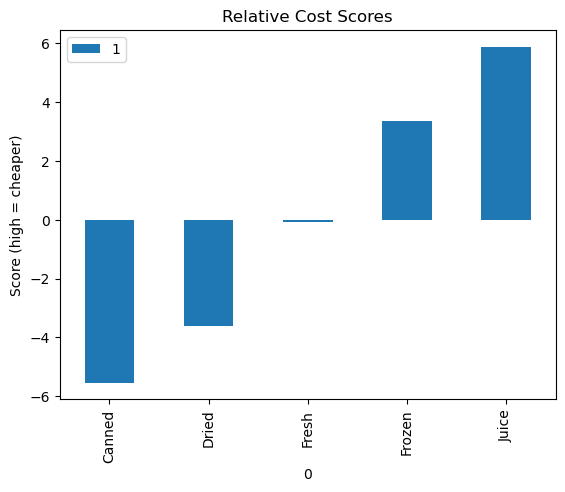

In [545]:
#sort the data for by Fruit type, then by cost with each type, then reindex by this new order
data = data.sort_values(["Fruit", "CupEquivalentPrice"]).reset_index()
data = data.drop(columns=['index'])

currFruit = ""
currForms = [] # list in order encountered, from cheapest to most expensive
scores = {}
for form in ["Canned", "Dried", "Fresh", "Frozen", "Juice"]:
    scores[form] = 0
for i in data.itertuples():
    if i.Fruit!=currFruit:
        for j in range(len(currForms)):
            degFree = len(currForms)-1 #degrees of freedom for ranking
            points = (degFree-j)/degFree #gives us a value between 1 and 0, inclusive
            points = points - 0.5 #shifts the scale to between 0.5 and -0.5 inclusive
            points = points * 2 # shift to between 1 and -1
            scores[currForms[j]] += points
        currForms = []
        currFruit = i.Fruit
    currForms.append(i.Form)

#higher scores reflect forms that are cheaper between forms within fruit types

scoreList = []
for i in scores:
    scoreList.append((i, scores[i]))
scoreFrame = pd.DataFrame(scoreList)
print(scoreFrame)

scoreFrame.plot.bar(title="Relative Cost Scores", x=0, y=1, ylabel="Score (high = cheaper)")